In [20]:
%matplotlib inline

import numpy as np 
import pandas as pd 

import os, math, random
from pathlib import Path

from tqdm import tqdm
from glob import glob
import gc

import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams['axes.titlesize'] = 12
sns.set_palette('Set3')
   
from time import time, strftime, gmtime

print(os.listdir('./data/'))

start = time()
print(start)

import datetime
print(str(datetime.datetime.now()))

import warnings
warnings.simplefilter('ignore')

['Outcomes-a.txt', 'sample_submission.csv', 'set-a', 'Test.csv', 'Test_data_dictionary.csv', 'Train.csv', 'Train_data_dictionary.csv']
1648652188.5030515
2022-03-30 16:56:28.504054


In [2]:
SEED = 42
def seed_everything(seed = SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
base_dir = './data/'

In [4]:
path_file = os.path.join(base_dir, "set-a", "*.txt")
input_files = glob(path_file)
print(f"Num of training files: {len(input_files)}")
input_files[:10]

Num of training files: 4000


['./data/set-a\\132539.txt',
 './data/set-a\\132540.txt',
 './data/set-a\\132541.txt',
 './data/set-a\\132543.txt',
 './data/set-a\\132545.txt',
 './data/set-a\\132547.txt',
 './data/set-a\\132548.txt',
 './data/set-a\\132551.txt',
 './data/set-a\\132554.txt',
 './data/set-a\\132555.txt']

##### Outcomes.txt fields
- RecordID (defined as above)
- SAPS-I score (Le Gall et al., 1984)
- SOFA score (Ferreira et al., 2001)
- Length of stay (days)
- Survival (days)
- In-hospital death (0: survivor, or 1: died in-hospital)

In [5]:
df_target = pd.read_csv(Path(base_dir) / "Outcomes-a.txt")
print(df_target.shape)
df_target.head()

(4000, 6)


,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


##### First extract the data in txt files to a Dataframe

In [6]:
features_to_use = ["RecordID", "Age", "Gender", "Height", "Weight", "Urine", "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH", 
                   "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "ICUType"]

In [7]:
# Check a single txt file
temp = pd.read_csv(np.random.choice(input_files, 1)[0])
temp.head()

,Time,Parameter,Value
0,00:00,RecordID,139595.0
1,00:00,Age,69.0
2,00:00,Gender,0.0
3,00:00,Height,-1.0
4,00:00,ICUType,4.0


In [8]:
def extract_to_dict(df: pd.DataFrame, features: list) -> pd.DataFrame:
    #Replace '-1' to NaNs
    df = df.replace(-1.0, np.nan)
    patient_dict = {}
    for feat in features:
        patient_dict[feat] = round(df[df['Parameter'] == feat]['Value'].mean(), 2)
    return pd.DataFrame(patient_dict, index = [0])

In [9]:
df = pd.DataFrame()

for file in tqdm(input_files):
    temp = pd.read_csv(file)
    df = df.append(extract_to_dict(temp, features_to_use))
print(df.shape)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:49<00:00, 81.33it/s]

(4000, 21)


,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,pH,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType
0,132539.0,54.0,0.0,NaN,NaN,171.05,70.81,37.36,50.15,NaN,...,NaN,NaN,NaN,203.00,NaN,4.20,136.50,NaN,14.92,4.0
0,132540.0,76.0,1.0,175.3,80.67,151.56,80.79,36.94,56.71,113.41,...,7.40,38.86,210.14,178.60,76.94,3.90,137.00,0.56,13.33,2.0
0,132541.0,44.0,0.0,NaN,56.70,124.95,83.76,37.80,79.00,125.69,...,7.49,35.50,134.50,89.67,90.44,4.26,138.33,0.50,5.92,3.0
0,132543.0,68.0,1.0,180.3,84.60,545.83,70.98,36.22,65.05,NaN,...,NaN,NaN,NaN,330.00,NaN,4.00,139.33,NaN,14.94,3.0
0,132545.0,88.0,0.0,NaN,NaN,62.13,74.96,36.88,45.72,NaN,...,NaN,NaN,NaN,103.00,NaN,4.32,139.50,NaN,15.00,3.0


##### Merge train features with target

In [10]:
#we just need the In-hospital_death from the target df
df = df.merge(df_target[['RecordID', 'In-hospital_death']], on = 'RecordID')
df.shape

(4000, 22)

In [11]:
#Save
df.to_csv('./icu_mortality_train.csv', index = False)
df.head()

,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,In-hospital_death
0,132539.0,54.0,0.0,NaN,NaN,171.05,70.81,37.36,50.15,NaN,...,NaN,NaN,203.00,NaN,4.20,136.50,NaN,14.92,4.0,0
1,132540.0,76.0,1.0,175.3,80.67,151.56,80.79,36.94,56.71,113.41,...,38.86,210.14,178.60,76.94,3.90,137.00,0.56,13.33,2.0,0
2,132541.0,44.0,0.0,NaN,56.70,124.95,83.76,37.80,79.00,125.69,...,35.50,134.50,89.67,90.44,4.26,138.33,0.50,5.92,3.0,0
3,132543.0,68.0,1.0,180.3,84.60,545.83,70.98,36.22,65.05,NaN,...,NaN,NaN,330.00,NaN,4.00,139.33,NaN,14.94,3.0,0
4,132545.0,88.0,0.0,NaN,NaN,62.13,74.96,36.88,45.72,NaN,...,NaN,NaN,103.00,NaN,4.32,139.50,NaN,15.00,3.0,0


In [12]:
# -1 is data unavailable, we convert them to NaNs
df = df.replace([-1.0, np.inf, -np.inf], np.nan)

In [13]:
df.columns

Index(['RecordID', 'Age', 'Gender', 'Height', 'Weight', 'Urine', 'HR', 'Temp',
       'NIDiasABP', 'SysABP', 'DiasABP', 'pH', 'PaCO2', 'PaO2', 'Platelets',
       'MAP', 'K', 'Na', 'FiO2', 'GCS', 'ICUType', 'In-hospital_death'],
      dtype='object')

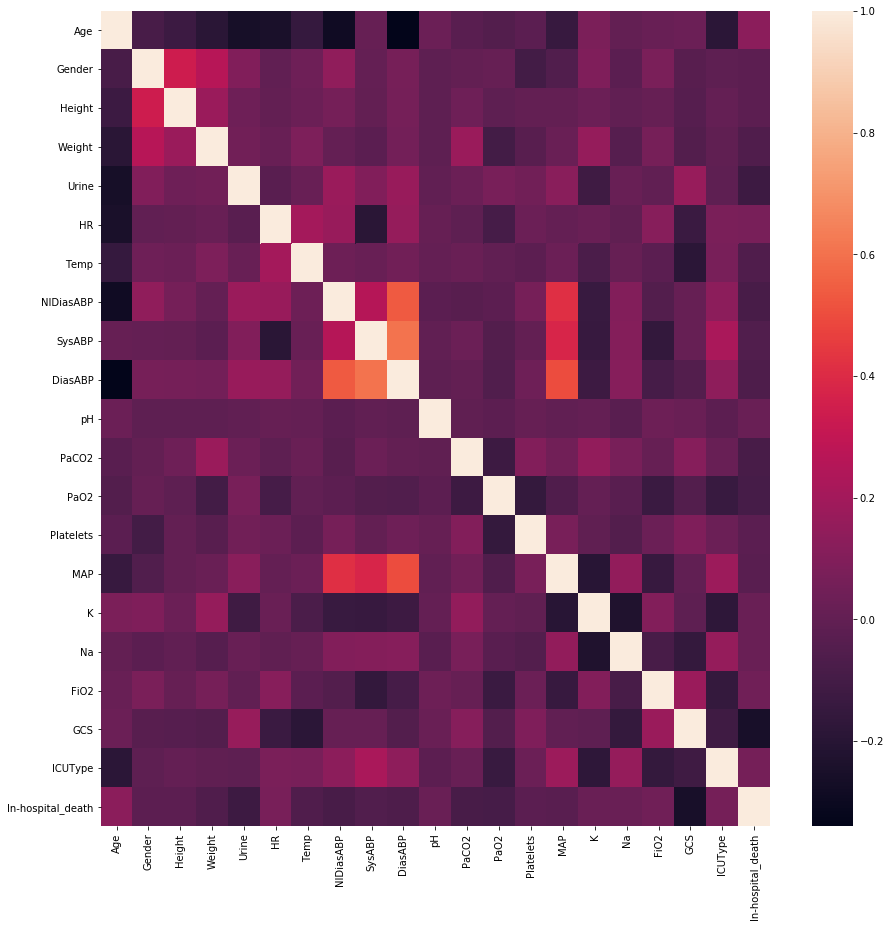

In [25]:
df_copy = df.drop("RecordID", axis=1)
corr = df_copy.corr()

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, xticklabels = corr.columns,  yticklabels=corr.columns)

### NaN Imputation
- Before proceeding with modeling and prediction we will have to impute the NaN values in the dataset
- We can impute all the NaNs with the respective feature's mean value
- But here we impute NaNs depending on the 'In-hospital_death' value

In [15]:
cat_features = ['Gender', 'ICUType', 'age_group', 'bmi_group']
num_features = [c for c in df.columns if c not in cat_features]
num_features = [c for c in num_features if c not in ['RecordID', 'In-hospital_death']]

In [16]:
df_0 = df[df['In-hospital_death'] == 0].copy()
df_1 = df[df['In-hospital_death'] == 1].copy()
#Impute Numerical Features with mean value
df_0[num_features] = df_0[num_features].fillna(df_0[num_features].mean())
df_1[num_features] = df_1[num_features].fillna(df_1[num_features].mean())

#Impute Categorical Features with most frequent value
for col in num_features:
    df_0[col] = df_0[col].fillna(df_0[col].value_counts().index[0])
    df_1[col] = df_1[col].fillna(df_1[col].value_counts().index[0])

#concat both df, shuffle and reset index
df = pd.concat([df_0, df_1], axis = 0).sample(frac = 1).reset_index(drop = True)
df.shape

(4000, 22)

In [17]:
print('Feature Correlation with target:')
df.corr()['In-hospital_death']

Feature Correlation with target:


RecordID            -0.011532
Age                  0.130700
Gender              -0.015689
Height              -0.029749
Weight              -0.059091
Urine               -0.124613
HR                   0.073804
Temp                -0.060056
NIDiasABP           -0.092159
SysABP              -0.066522
DiasABP             -0.075262
pH                   0.027729
PaCO2               -0.095989
PaO2                -0.100565
Platelets           -0.021218
MAP                 -0.032993
K                    0.022343
Na                   0.022402
FiO2                 0.052448
GCS                 -0.256607
ICUType              0.059896
In-hospital_death    1.000000
Name: In-hospital_death, dtype: float64

### Label Encoding & Standardization

- __Standardization__: Handle outliers better; Mean 0, Std: 1
- __Normalization__: Doesn't handle outliers well; 0 to 1 Range

In [23]:
df['age_group'] = pd.cut(df['Age'], bins = 9, labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])

In [26]:
from sklearn.preprocessing import *

#Label Encoding age, gender, category
for col in ['Gender', 'ICUType', 'age_group']:
    print(f"Label Encoding: {col} - {df[col].nunique()}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Label Encoding: Gender - 5
Label Encoding: ICUType - 4
Label Encoding: age_group - 9


In [27]:
std = StandardScaler()
df[num_features] = std.fit_transform(df[num_features])

In [28]:
X = df.drop(['RecordID', 'In-hospital_death'], axis = 1)
y = df['In-hospital_death'].copy()

In [29]:
#scale_pos_weight - sample Weights
num_pos_samples = y.value_counts().values[1]
num_neg_samples = y.value_counts().values[0]

class_weight = num_neg_samples / num_pos_samples
print(f"scale_pos_weight:")
num_neg_samples / num_pos_samples, np.sqrt(num_neg_samples / num_pos_samples)

scale_pos_weight:


(6.2202166064981945, 2.4940362079364835)

In [30]:
def plot_pr_curve(precision, recall, avg_precision):
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = f"Avg. PR: {round(avg_precision, 2)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.55, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [31]:
def plot_confusion(mat):
    plt.figure(figsize = (8, 4))
    sns.heatmap(pd.DataFrame(mat), annot = True, annot_kws = {"size": 25}, cmap = 'Blues', fmt = 'g')
    plt.title('Confusion matrix', y = 1.1, fontsize = 22)
    plt.ylabel('Actual', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.show()

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

xgb_params = {
         'objective': 'binary:logistic',
         'lambda': 0.0030282073258141168, 
         'alpha': 0.01563845128469084,
         'colsample_bytree': 0.55,
         'subsample': 0.7,
         'learning_rate': 0.01,
         'max_depth': 9,
         'random_state': 2020, 
         'min_child_weight': 257,
         'eval_metric': 'aucpr',
         'seed': 2021,
         'scale_pos_weight': num_neg_samples / num_pos_samples #np.sqrt(num_neg_samples / num_pos_samples)
         }

In [33]:
import lightgbm as lgbm

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': None,
        'learning_rate': 0.02,
        'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': -1
}

def pr_score(preds, train_data):
    aps = average_precision_score(train_data.get_label(), preds)
    return 'aps', aps, False

In [34]:
def compute_precision_recall(conf_mat):
    #compute precision and recall
    tp_and_fn = conf_mat.sum(axis = 1)
    tp_and_fp = conf_mat.sum(axis = 0)
    tp = conf_mat.diagonal()
    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    return precision, recall

In [35]:
model_type = 'xgbclassifier'

###########################################################################################
Fold: 1
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9322136120204447


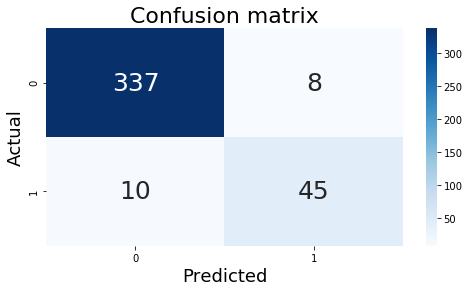

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       345
           1       0.85      0.82      0.83        55

    accuracy                           0.95       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.95      0.95      0.95       400


###########################################################################################
Fold: 2
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9159325630032028


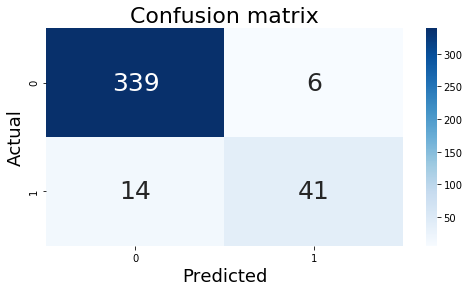

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       345
           1       0.87      0.75      0.80        55

    accuracy                           0.95       400
   macro avg       0.92      0.86      0.89       400
weighted avg       0.95      0.95      0.95       400


###########################################################################################
Fold: 3
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.93986602034851


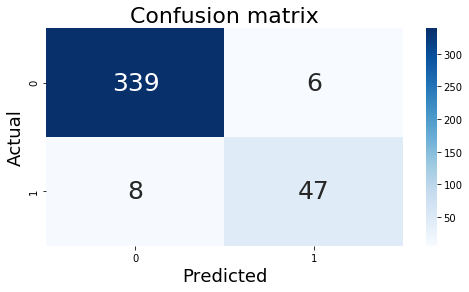

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       345
           1       0.89      0.85      0.87        55

    accuracy                           0.96       400
   macro avg       0.93      0.92      0.93       400
weighted avg       0.96      0.96      0.96       400


###########################################################################################
Fold: 4
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9158800544943879


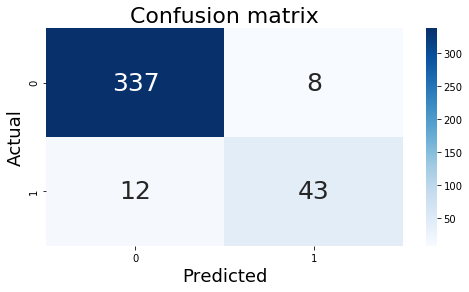

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       345
           1       0.84      0.78      0.81        55

    accuracy                           0.95       400
   macro avg       0.90      0.88      0.89       400
weighted avg       0.95      0.95      0.95       400


###########################################################################################
Fold: 5
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9128720273190348


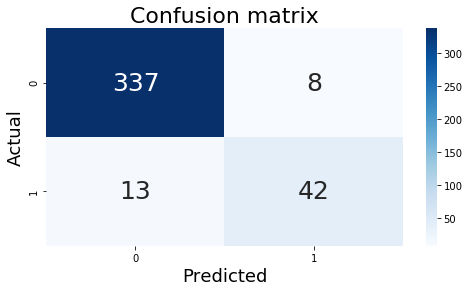

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       345
           1       0.84      0.76      0.80        55

    accuracy                           0.95       400
   macro avg       0.90      0.87      0.88       400
weighted avg       0.95      0.95      0.95       400


###########################################################################################
Fold: 6
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9178602434026036


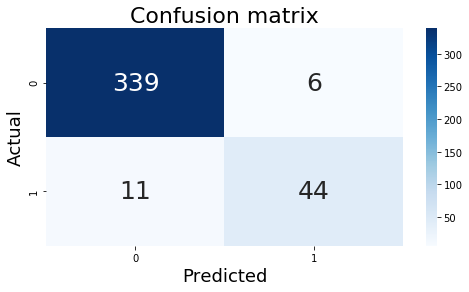

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       345
           1       0.88      0.80      0.84        55

    accuracy                           0.96       400
   macro avg       0.92      0.89      0.91       400
weighted avg       0.96      0.96      0.96       400


###########################################################################################
Fold: 7
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9577287721240185


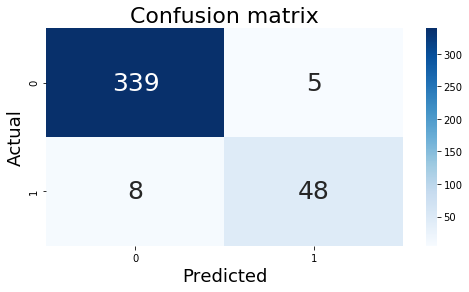

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       344
           1       0.91      0.86      0.88        56

    accuracy                           0.97       400
   macro avg       0.94      0.92      0.93       400
weighted avg       0.97      0.97      0.97       400


###########################################################################################
Fold: 8
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9446528881728619


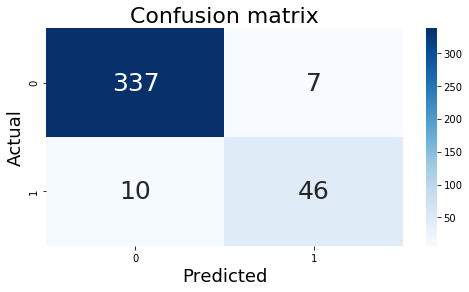

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       344
           1       0.87      0.82      0.84        56

    accuracy                           0.96       400
   macro avg       0.92      0.90      0.91       400
weighted avg       0.96      0.96      0.96       400


###########################################################################################
Fold: 9
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9159864050862973


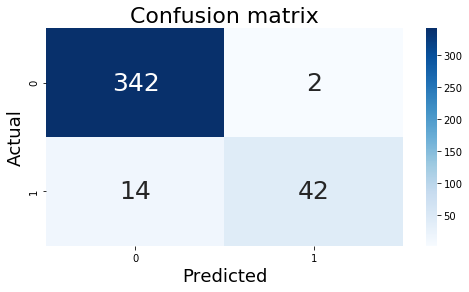

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       344
           1       0.95      0.75      0.84        56

    accuracy                           0.96       400
   macro avg       0.96      0.87      0.91       400
weighted avg       0.96      0.96      0.96       400


###########################################################################################
Fold: 10
(3600, 21) (3600,) (400, 21) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.9265786701967179


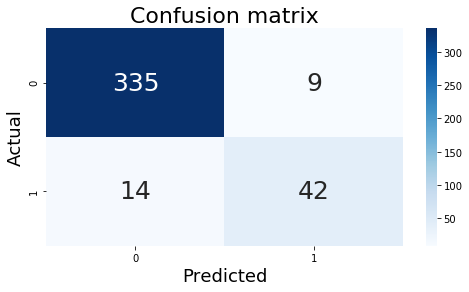

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       344
           1       0.82      0.75      0.79        56

    accuracy                           0.94       400
   macro avg       0.89      0.86      0.88       400
weighted avg       0.94      0.94      0.94       400




In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

n_folds = 10
preds_xg = []
overall_pr = []
all_precision, all_recall = [], []

skf = StratifiedKFold(n_splits = n_folds)
#rkf = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 42)

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('#############' * 7)
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape)
    print(f"Classifier: {model_type}")
    print('#############' * 7)
    
    if model_type == 'lgbm':
        ltrain = lgbm.Dataset(Xtrain, label = ytrain)
        lvalid = lgbm.Dataset(Xvalid, label = yvalid)

        model = lgbm.train(params,
                ltrain,
                num_boost_round = 2000,
                valid_sets = [ltrain, lvalid],
                verbose_eval = 250,
                early_stopping_rounds = 100, 
                feval = pr_score)

        valid_preds = model.predict(Xvalid)
        
    if model_type == 'xgboost':
        xg_train = xgb.DMatrix(Xtrain, label = ytrain)
        xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

        clf = xgb.train(params,
                          xg_train,
                          5000,
                          verbose_eval = 50,
                          evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                          early_stopping_rounds = 100
                       )

        valid_preds = clf.predict(xg_valid)
    
    if model_type == 'xgbclassifier':
        clf = XGBClassifier(scale_pos_weight = class_weight, eval_metric = 'aucpr',
                                random_state = 42, n_jobs = -1)
        clf.fit(Xtrain, ytrain)
        valid_preds = clf.predict_proba(Xvalid)[:, 1]
        
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    overall_pr.append(avg_precision)
    
    #precision, recall, _ = precision_recall_curve(yvalid, valid_preds)
    #plot_pr_curve(precision, recall, avg_precision)
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    #compute precision and recall
    pre, rec = compute_precision_recall(conf_mat)
    all_precision.append(pre)
    all_recall.append(rec)
    plot_confusion(conf_mat)
    
    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")
    
    preds_xg.append(valid_preds)
    print()

In [39]:
print(f"\t\t Overall Avg CV Score: {np.mean(overall_pr)}")
print(f"\t\t Avg. Precision: {np.mean(all_precision)}\n\t\t Avg. Recall: {np.mean(all_recall)}")

		 Overall Avg CV Score: 0.927957125616808
		 Avg. Precision: 0.9198592108026569
		 Avg. Recall: 0.8876804098328364


In [40]:
display(HTML(f"<h1></b>- Precision at {round(np.mean(all_precision) * 100, 2)}% means that when our model predicts the mortality it is correct {round(np.mean(all_precision) * 100, 2)}% of the time </b></h1>"))
display(HTML(f"<h1></b>- Recall at {round(np.mean(all_recall) * 100, 2)}% means that our model correctly identifies {round(np.mean(all_recall) * 100, 2)}% of all mortality in patients </b></h1>"))

# Model Explainability by SHAP

In [41]:
%%time
import shap

#Shap values with XGBoost core model
#Getting the shap values using the model is faster than usual way
booster_xgb = clf.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(Xtrain, ytrain), pred_contribs = True)

Wall time: 921 ms


In [42]:
shap_values_xgb = shap_values_xgb[:, :-1]
print(shap_values_xgb.shape)
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns.tolist()).head()

(3600, 21)


,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,age_group
0,-1.443691,0.108687,-5.245642,-0.260497,-0.640286,0.023693,-0.261013,-0.213255,-0.124803,-0.179599,...,-0.995164,-0.264544,-0.035810,0.021047,-0.340729,-0.413609,-0.045216,-0.500300,0.210544,0.003273
1,-1.816381,0.043272,-1.555412,-0.089878,-0.640758,-0.035174,-0.212311,-2.447953,-0.200093,-0.297617,...,-0.915410,-0.216250,0.395772,-0.080553,-0.038307,-0.523308,-0.334506,-1.259464,-0.477293,-0.004207
2,-0.699265,0.011836,-5.229279,-0.334233,-0.666933,0.768687,-0.570559,0.072243,0.895737,-0.015997,...,-0.413027,0.420729,0.195397,0.021025,-0.128623,0.850351,0.342164,-0.727116,0.145750,-0.000823
3,-0.485763,-0.065634,0.796974,0.186518,-0.667525,0.137430,1.328379,1.092931,-1.046708,0.050444,...,1.169471,0.642569,-0.029610,-0.059640,-0.094238,0.324248,2.708477,-0.784370,0.302027,-0.008455
4,-0.686547,-0.073768,0.385160,-0.053492,1.502852,0.248608,0.744397,-0.828987,1.187876,-0.105420,...,0.766335,-0.064187,0.241635,0.324844,-0.017767,-0.056564,-0.314489,0.800409,0.228296,-0.006807


# Feature Importances

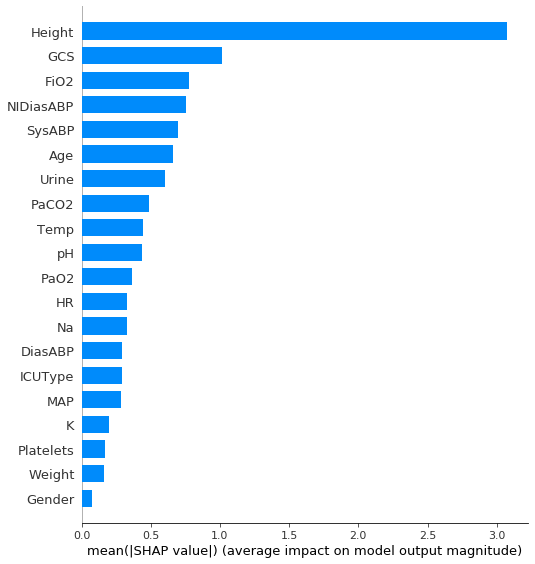

In [43]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns, plot_type = "bar")

In [44]:
#importances are just the average absolute Shapley values for a feature. We can check that below:
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns)["GCS"].abs().mean()

1.0147673

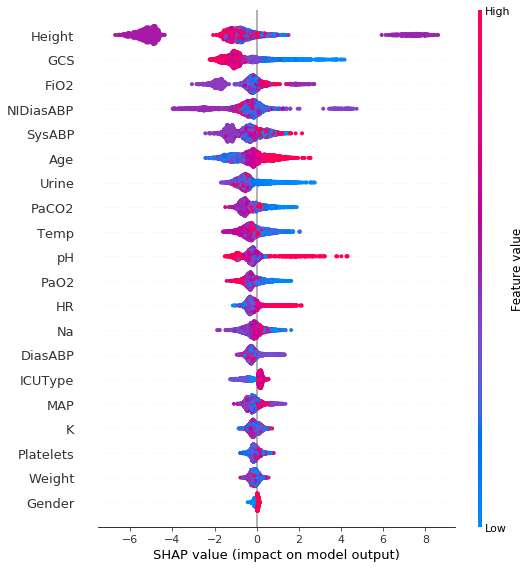

In [45]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns);

**Comment:**
>- The horizontal axis represents the magnitude of the SHAP values for predictions.
>- The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points.
>- We see that as GCS increases, its effect on the model is more positive.

In [46]:
%%time
#SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(xgb.DMatrix(Xtrain, ytrain), pred_interactions = True)
interactions_xgb.shape

Wall time: 15.2 s


(3600, 22, 22)

## Top K Interactions between features

In [47]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key = lambda x: x[1], reverse = True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]


top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(Xtrain.columns, interactions_xgb, 10)

In [48]:
top_10_inter_feats

('GCS-Height',
 'Na-NIDiasABP',
 'Urine-Height',
 'PaO2-SysABP',
 'Temp-Height',
 'NIDiasABP-Height',
 'PaCO2-Height',
 'SysABP-Height',
 'GCS-FiO2',
 'Height-Age')

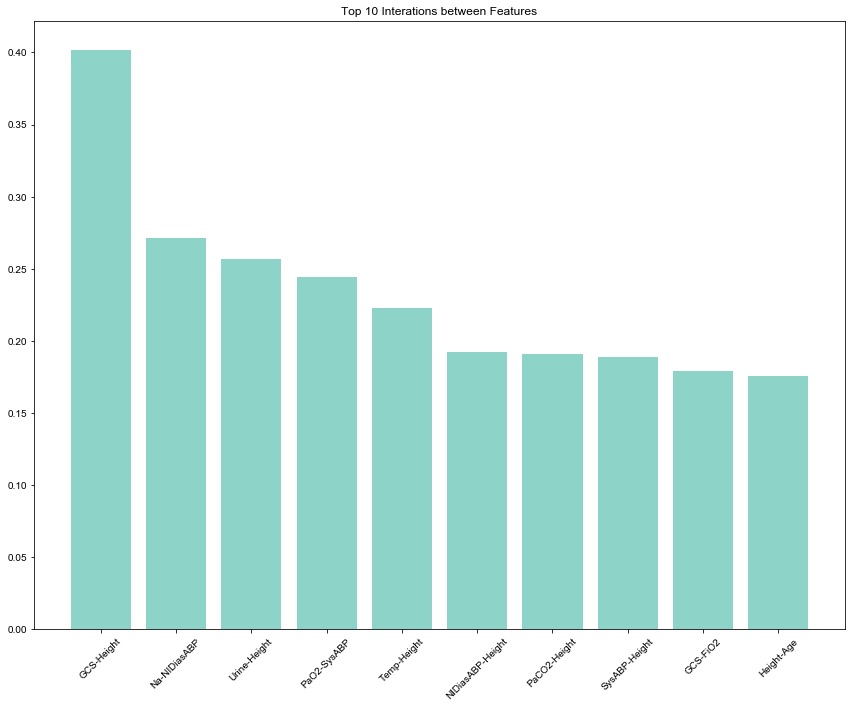

In [49]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    sns.set_theme(style="darkgrid")
    plt.xticks(rotation = 45)
    plt.title('Top 10 Interations between Features')
    plt.tight_layout()
    plt.show()
    
top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(Xtrain.columns, interactions_xgb, 10)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

- GCS feature interacts with most of the other feautures

# Local Interpretability

In [50]:
random_idx = np.random.randint(len(Xtrain))
random_idx

174

In [51]:
%%time
#Create a tree explainer
xgb_explainer = shap.TreeExplainer(clf, Xtrain, feature_names = Xtrain.columns.tolist())

#Recalculate SHAP values
shap_explainer_values = xgb_explainer(Xtrain, ytrain)

Wall time: 9.72 s


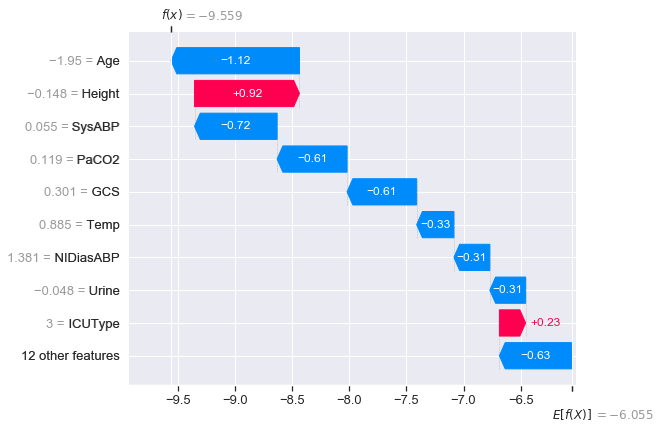

In [52]:
shap.waterfall_plot(shap_explainer_values[random_idx])

**Comment:**
>- The thin line in the middle denotes the mean prediction. The vertical axis shows the feature values of the random_idx. The bars represent how each feature property shifted the prediction from the mean prediction. The red bars represent positive shifts; the blue bars represent negative shifts.

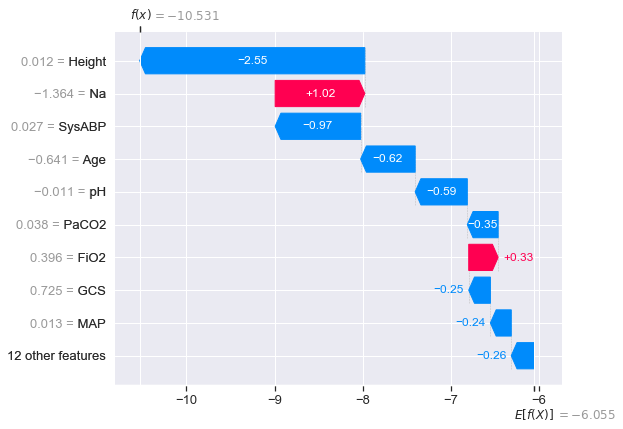

In [53]:
shap.waterfall_plot(shap_explainer_values[100])

**Comment:**
>- The waterfall_plot above is same as the Shap Force plot
>- Features in red push the prediction to postive - 1 while the features in blue makes the prediction move towards 0

### Interpretability of GRU-D Model

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

In [58]:
attr_list = [ "RecordID", "Age", "Gender", "Height", "ICUType", "Weight",
                "Albumin", "ALP", "ALT", "AST", "Bilirubin", "BUN", "Cholesterol",
                "Creatinine", "DiasABP", "FiO2", "GCS", "Glucose", "HCO3", "HCT",
                "HR", "K", "Lactate", "Mg", "MAP", "MechVent", "Na", "NIDiasABP",
                "NIMAP", "NISysABP", "PaCO2", "PaO2", "pH", "Platelets", 
                "RespRate", "SaO2", "SysABP", "Temp", "TroponinI", "TroponinT",
                "Urine", "WBC"]

In [65]:
import torch.utils.data as utils
from sklearn.model_selection import train_test_split

def get_dataloaders(dataset, outcomes, x_mean, BATCH_SIZE, max_feats=49, test_proportion=0.2):
    train_data, test_data, train_label, test_label = train_test_split(dataset, outcomes, test_size=test_proportion, random_state=42)    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    #valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)

    train_dataset = utils.TensorDataset(train_data, train_label)
    #valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)

    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
    #valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

    print("\t\t train_dataset: ", train_data.shape)
    print("\t\t test_data: ", test_data.shape)

    x_mean = torch.mean(train_data[:, 0], axis = 0)

    #return train_dataloader, valid_dataloader, test_dataloader, max_feats, x_mean
    return train_dataloader, test_dataloader, max_feats, x_mean                                                   

In [66]:
class GRU_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRU_decoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, 
                          batch_first=batch_first, dropout=gru_dropout)
        self.hidden_size = hidden_size
        self.decoder = nn.Sequential(
                                    nn.BatchNorm1d(hidden_size),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax()
                                    )
  
    def forward(self, x):
        _, hidden = self.gru(x)
        output = self.decoder(hidden.view(batch_size, self.hidden_size))

        return output

In [67]:
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
        
        # initialize weights and biases
        self.W_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_r = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_r = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_z = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_z = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_gamma_x = nn.Parameter(torch.FloatTensor(input_size).normal_(0, 0.02))
        self.b_gamma_x = nn.Parameter(torch.FloatTensor(input_size).zero_())

        self.W_gamma_h = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_gamma_h = nn.Parameter(torch.FloatTensor(hidden_size).zero_())
        self.gru_dropout = gru_dropout
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.decoder_dropout = nn.Dropout(p=decoder_dropout)
        self.register_buffer('X_last_obs', torch.zeros(input_size))
        
    def forward(self, x, delta, m, h_t=None):
        """
        
        :param x: features input [batch_size, seq_len, num_features]
        :param delta: time interval of feature observation [batch_size, seq_len, num_features]
        :param m: masking vector {0, 1} of [batch_size, seq_len, num_features]
        :param x_forward: place to replace missing values with [b, seqlen, numf]
        :param h_t: initial hidden state [batch_size, seq_len, hidden_size]
        :return: output [batch_size, output_size], hidden_state [batch_size, hidden_size]
        """
        batch_size, seq_len, input_size = x.size()
        
        x_forward = getattr(self, 'X_last_obs')
        
        if h_t is None:
            # initialize to zero
            h_t = Variable(torch.FloatTensor(batch_size, self.hidden_size).zero_())
            if x.is_cuda:
                h_t = h_t.cuda()
          
        # compute decays
        decay_x = delta*self.W_gamma_x + self.b_gamma_x
        zeroes = Variable(torch.zeros(decay_x.size()))
        if decay_x.is_cuda:
            zeroes = zeroes.cuda()
        gamma_x_t = torch.exp(-torch.max(zeroes, decay_x))
            
        decay_h = torch.matmul(m, self.W_gamma_h) + self.b_gamma_h
        zeroes = Variable(torch.zeros(decay_h.size()))
        if decay_h.is_cuda:
            zeroes = zeroes.cuda()
        gamma_x_h = torch.exp(-torch.max(zeroes, decay_h))
            
        # replace missing values
        x_replace = decay_x * x_forward + (1-decay_x) * 0.001
        x[m.byte()] = x_replace[m.byte()]
                  
        # dropout masks, one for each batch
        dropout_rate = self.gru_dropout if self.training else 0.
        
        W_dropout = Variable((torch.FloatTensor(self.W.size()).uniform_() > dropout_rate).float())
        U_dropout = Variable((torch.FloatTensor(self.U.size()).uniform_() > dropout_rate).float())
        V_dropout = Variable((torch.FloatTensor(self.V.size()).uniform_() > dropout_rate).float())
        
        if decay_h.is_cuda:
            W_dropout = W_dropout.cuda()
            U_dropout = U_dropout.cuda()
            V_dropout = V_dropout.cuda()
        
        for t in range(seq_len):
            # decay h
            update_range = Variable(torch.LongTensor(list(range(batch_size))))
            if decay_h.is_cuda:
                update_range = update_range.cuda()
            h_t = h_t.clone().index_copy_(0, update_range, gamma_x_h[:batch_size,t,:] * h_t[:batch_size])

            z_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_z) + torch.matmul(h_t[:batch_size], self.U_z) + torch.matmul(1-m[:batch_size, t, :], self.V_z) + self.b_z)
            r_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_r) + torch.matmul(h_t[:batch_size], self.U_r) + torch.matmul(1-m[:batch_size, t, :], self.V_r) + self.b_r)
            h_tilde_t = F.tanh(torch.matmul(x[:batch_size, t, :], self.W*W_dropout) + torch.matmul(h_t[:batch_size]*r_t, self.U*U_dropout) + torch.matmul(1-m[:batch_size, t, :], self.V*V_dropout) + self.b)
            h_t = h_t.clone()
            h_t = h_t.clone().index_copy_(0, update_range, (1 - z_t) * h_t[:batch_size] + z_t * h_tilde_t)
            
        if batch_size > 1:
            h_t = self.bn(h_t)

        output = F.log_softmax(self.decoder(self.decoder_dropout(h_t)), dim=-1)
        
        return output, h_t

In [68]:
NUM_FEATURES = 49
hidden_size = 64
gru_dropout = 0.3
decoder_dropout = 0.5
output_size = 2

model = GRUD(NUM_FEATURES, 49, output_size, gru_dropout, decoder_dropout)

In [72]:
PATH = "gru_d_60_EPOCHS"
model.load_state_dict(torch.load(PATH))
model.eval()

GRUD(
  (decoder): Linear(in_features=49, out_features=2, bias=True)
  (bn): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dropout): Dropout(p=0.5, inplace=False)
)

In [73]:
dataset = np.load("./data/dataset.npy")
outcomes = pd.read_csv('./data/Outcomes-a.txt')
labels = np.load("./data/y1_out.npy", allow_pickle=True)
print("\t\t labels shape: ", labels.shape)
xmean = np.load("./data/x_mean_aft_nor.npy", allow_pickle=True)
B_SIZE = 32

#train_loader, valid_dataloader, test_loader, max_feats, X_mean = get_dataloaders(dataset, outcomes['In-hospital_death'].to_numpy(), xmean, BATCH_SIZE = B_SIZE)
train_loader, test_loader, max_feats, X_mean = get_dataloaders(dataset, outcomes['In-hospital_death'].to_numpy(), xmean, BATCH_SIZE = B_SIZE)

		 labels shape:  (4000, 1)
		 train_dataset:  torch.Size([3200, 3, 33, 49])
		 test_data:  torch.Size([800, 3, 33, 49])


In [75]:
(data, label) = next(iter(train_loader))
x, m, delta = data[:, 0], data[:, 1], data[:, 2]

In [79]:
index = 14
explainer = shap.KernelExplainer(model, data)
shap_values = explainer.shap_values(Xtest)
#print("\t\t Probability prediction of the model: ", model.predict_proba(X_test[index].reshape(1, -1))[0])
print("\t\t Prediction of the model: ", model.predict(Xtest[index].reshape(1, -1))[0])

print("\t\t Contribution of all features: ", np.sum(shap_values[0][index]))
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], X_test_DF.iloc[index])

AssertionError: Unknown type passed as data object: <class 'torch.Tensor'>